In [110]:
library(tidyverse)
library(WGCNA)
library(cowplot)
library(matrixStats)

# Custom package
library(rutils)

In [111]:
options(stringsAsFactors = FALSE)
enableWGCNAThreads()

Allowing parallel execution with up to 15 working processes.


In [112]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

event_code <- list("Alive" = 0, "Dead" = 1)

In [113]:
dset_idx <- 3

# Load data

In [114]:
lnames <- load(file = paste0(dirs$data_dir, "/saved_network_objects/", unified_dsets[dset_idx], "_tumor_data.RData"))
filtered_matrisome_df <- load_matrisome_df(matrisome_path) %>%
    dplyr::select(gene_symbol, division, category, gene_name, synonyms) %>%
    dplyr::filter(gene_symbol %in% colnames(data_expr))    # Only include genes in dataset


Parsed with column specification:
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthology = col_character(),
  Notes = col_character()
)


# Find soft thresholding power

In [115]:
sft <- pickSoftThreshold(data = data_expr, verbose = FALSE)

   Power SFT.R.sq   slope truncated.R.sq  mean.k. median.k. max.k.
1      1 0.000896  0.0855          0.974 120.0000  1.20e+02 188.00
2      2 0.481000 -1.3300          0.976  24.5000  2.29e+01  63.10
3      3 0.841000 -1.8800          0.983   6.9200  5.57e+00  30.10
4      4 0.915000 -1.9500          0.945   2.5100  1.63e+00  17.50
5      5 0.940000 -1.8200          0.964   1.1000  5.40e-01  11.30
6      6 0.974000 -1.6100          0.975   0.5590  2.00e-01   7.80
7      7 0.921000 -1.5500          0.910   0.3190  7.95e-02   5.62
8      8 0.913000 -1.4300          0.890   0.1990  3.33e-02   4.19
9      9 0.915000 -1.4000          0.891   0.1320  1.45e-02   3.39
10    10 0.957000 -1.3700          0.945   0.0925  6.63e-03   2.91
11    12 0.326000 -2.0600          0.254   0.0512  1.51e-03   2.29
12    14 0.348000 -2.9600          0.311   0.0318  3.49e-04   1.94
13    16 0.383000 -3.1900          0.297   0.0216  9.00e-05   1.73
14    18 0.416000 -3.2800          0.280   0.0157  2.23e-05   

In [116]:
sft_df <- sft$fitIndices %>%
    as_tibble() %>%
    rename_with(function(c) { gsub("_$", "", tolower(gsub("\\.", "_", c))) }) %>%
    dplyr::mutate(scale_free_topology = -sign(slope) * sft_r_sq)
head(sft_df)

power,sft_r_sq,slope,truncated_r_sq,mean_k,median_k,max_k,scale_free_topology
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0008959414,0.08547265,0.9738006,119.971872,119.8793471,188.401297,-0.0008959414
2,0.4814040666,-1.33449115,0.9759295,24.460481,22.9280521,63.086422,0.4814040666
3,0.8407432793,-1.88293805,0.9830065,6.924949,5.5695701,30.093757,0.8407432793
4,0.9148126221,-1.94971782,0.9454136,2.505773,1.6332414,17.517943,0.9148126221
5,0.9398746342,-1.82394364,0.9644628,1.098687,0.5400144,11.308594,0.9398746342
6,0.9739255136,-1.61417553,0.9752160,0.559268,0.1997237,7.795402,0.9739255136


## Visualize

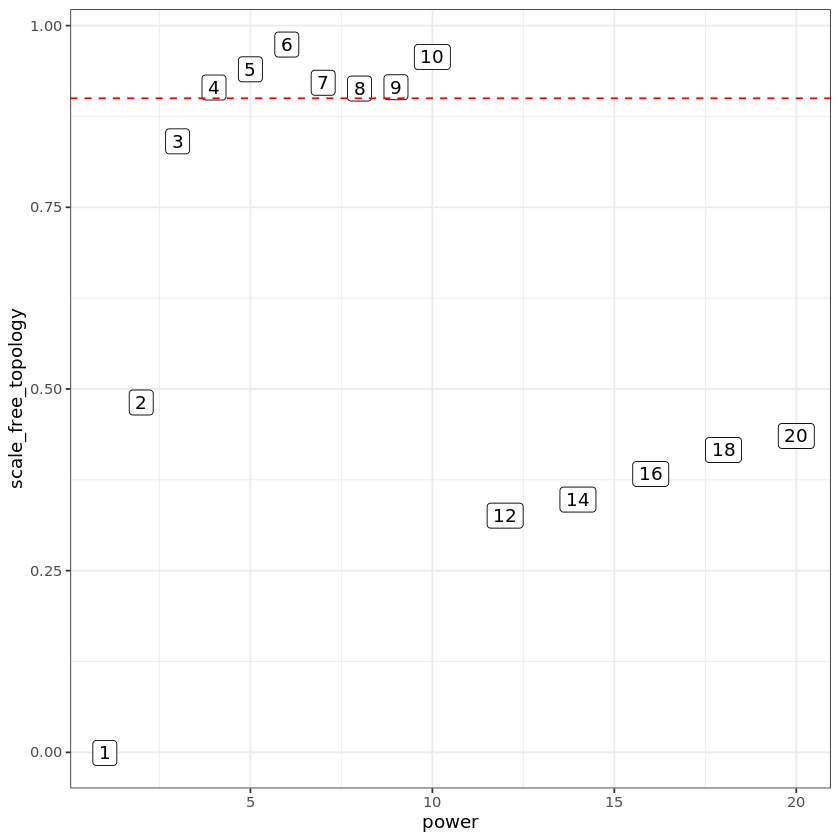

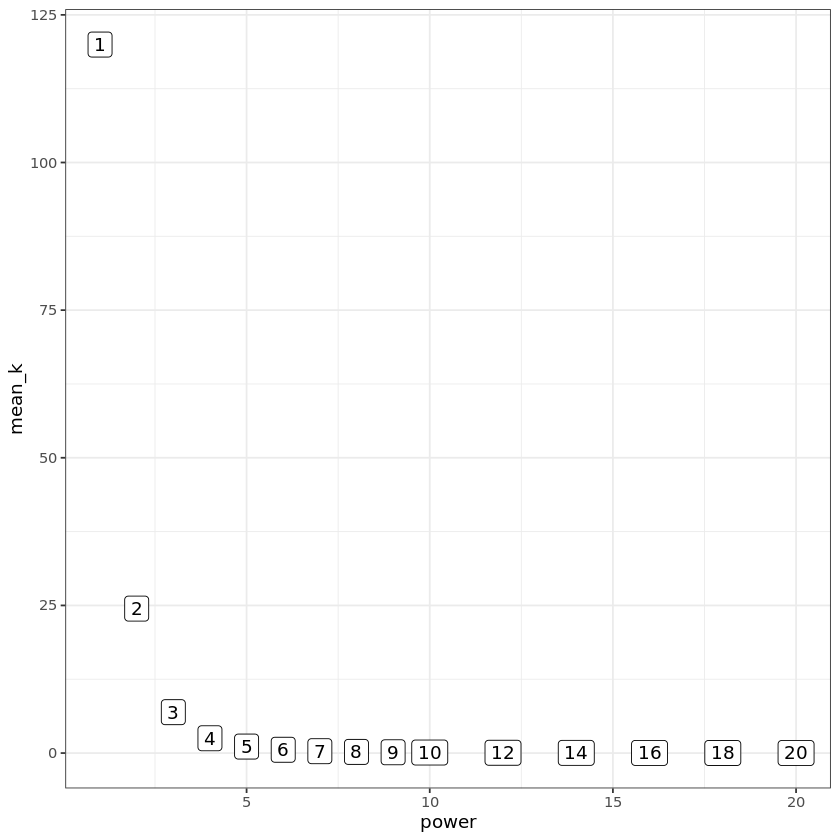

In [117]:
# sft_df
plt_1 <- ggplot(sft_df) +
    geom_label(aes(x = power, y = scale_free_topology, label = power)) +
    geom_hline(yintercept = 0.9, color = "red", linetype = "dashed") +
    theme_bw()
plt_2 <- ggplot(sft_df) +
    geom_label(aes(x = power, y = mean_k, label = power)) +
    theme_bw()
# plot_grid(plt_1, plt_2, labels = c("A", "B"), rows = 1, align="h")
plt_1
plt_2

In [118]:
# Pick first power which yields close to 0.9 scale free topology
thresh <- 0.9
tol <- 1e-2

soft_power <- sft_df %>%
    dplyr::filter(scale_free_topology > 0.9 | abs(scale_free_topology - thresh) < tol) %>%
    top_n(n = 1, wt = desc(power)) %>%
    dplyr::pull(power)

In [119]:
soft_power

[1] 4

# Adjacency

In [120]:
adj <- adjacency(data_expr, power = soft_power, corOptions = list(method = "pearson"), type = "unsigned")

# Topological Overlap Matrix (TOM)

In [121]:
tom <- TOMsimilarity(adj)
diss_tom <- 1 - tom

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


# Cluster on TOM

In [122]:
gene_tree <- hclust(as.dist(diss_tom), method = "average")

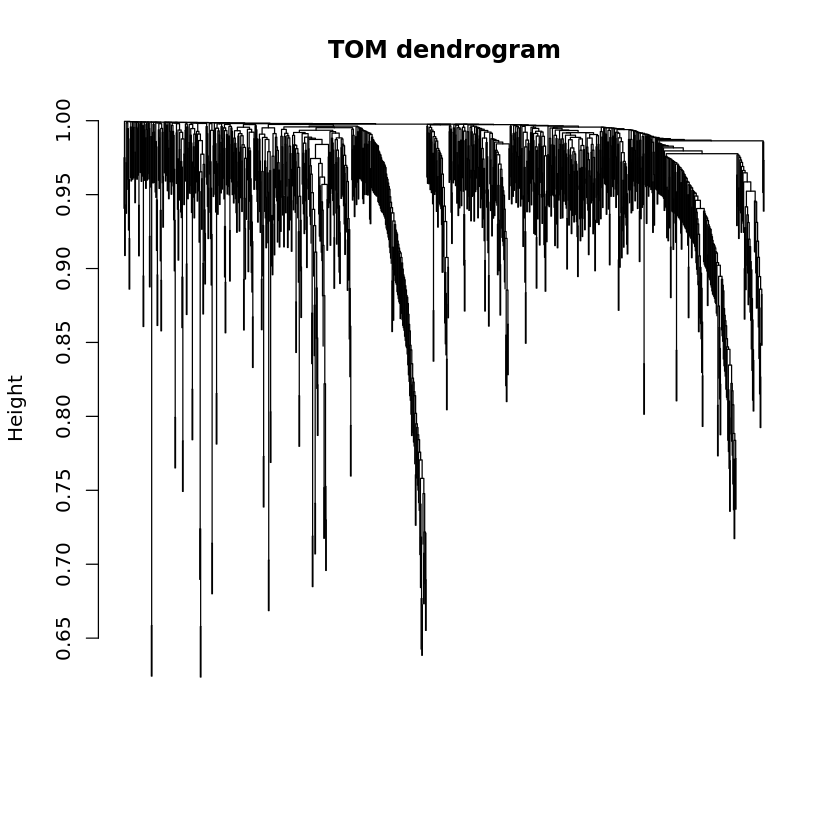

In [123]:
plot(gene_tree, labels = FALSE, xlab="", sub="", main = "TOM dendrogram")

In [124]:
# Set min. module size to 1/2 * min. matrisome category size
min_module_size <- filtered_matrisome_df %>%
    dplyr::group_by(category) %>%
    dplyr::summarize(n = n()) %>%
    top_n(n = 1, wt = desc(n)) %>%
    dplyr::pull(n) %>%
    (function(x) { round(x / 2) })

min_module_size

`summarise()` ungrouping output (override with `.groups` argument)


[1] 18

In [125]:
dynamic_mods <- cutreeDynamic(
    dendro = gene_tree, 
    distM = diss_tom, 
    deepSplit = 4, 
    pamRespectsDendro = FALSE, 
    minClusterSize = min_module_size
)
table(dynamic_mods)

 ..cutHeight not given, setting it to 0.998  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamic_mods
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14 
 41 219 125 102  71  70  65  53  45  45  45  43  33  28  22 

dynamic_colors
      black        blue       brown        cyan       green greenyellow 
         53         125         102          22          70          43 
       grey     magenta        pink      purple         red      salmon 
         41          45          45          45          65          28 
        tan   turquoise      yellow 
         33         219          71 

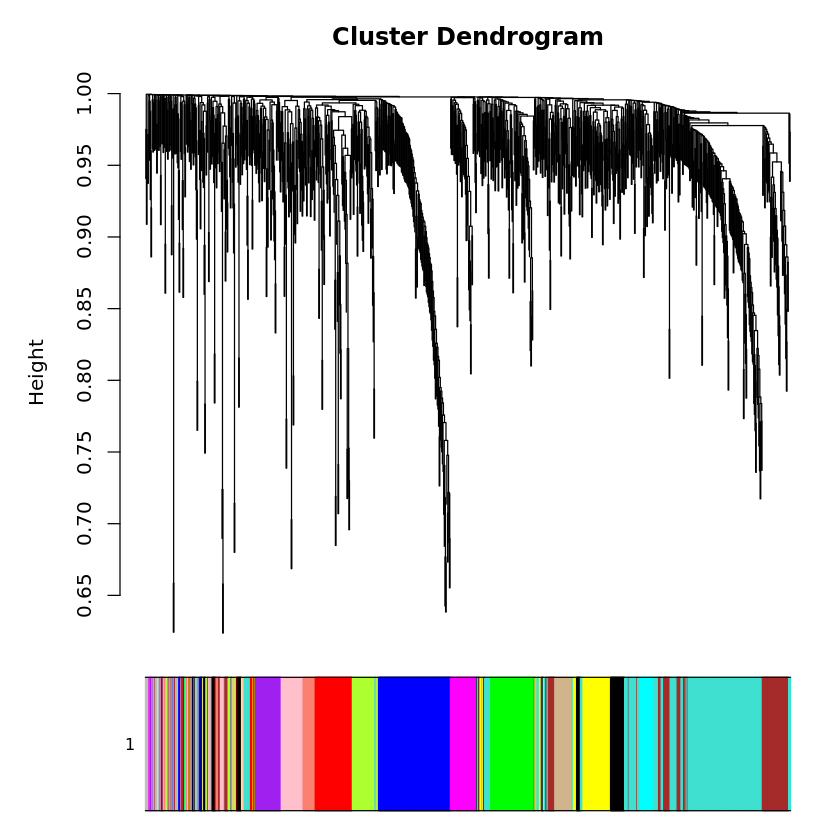

In [126]:
dynamic_colors <- labels2colors(dynamic_mods)
table(dynamic_colors)
plotDendroAndColors(gene_tree, dynamic_colors, dendroLabels = FALSE)

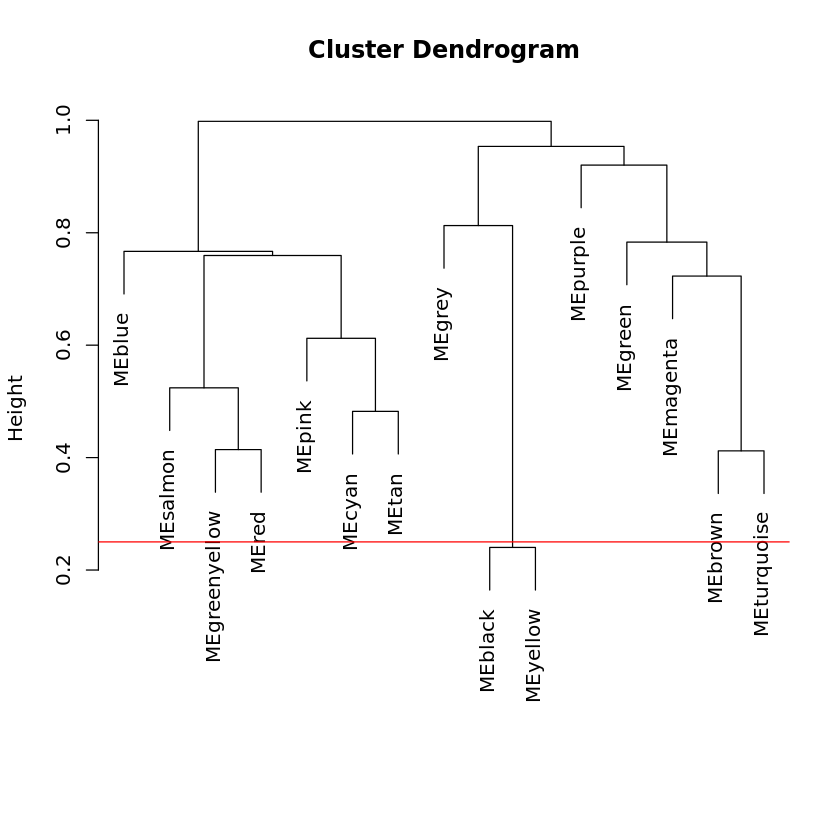

In [127]:
me_list <- moduleEigengenes(data_expr, colors = dynamic_colors)
mes <- me_list$eigengenes
me_diss <- 1 - WGCNA::cor(mes)
me_tree <- hclust(as.dist(me_diss), method = "average")
plot(me_tree, xlab = "", sub = "")

# Choose a correlation threshold
cor_thresh <- 0.75
me_diss_thresh <- 1 - cor_thresh
abline(h = me_diss_thresh, col = "red")

In [128]:
merged <- mergeCloseModules(data_expr, dynamic_colors, cutHeight = me_diss_thresh, verbose = 3)

 mergeCloseModules: Merging modules whose distance is less than 0.25
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 15 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 14 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 14 module eigengenes in given set.


In [129]:
merged_colors <- merged$colors
merged_mes <- merged$newMEs

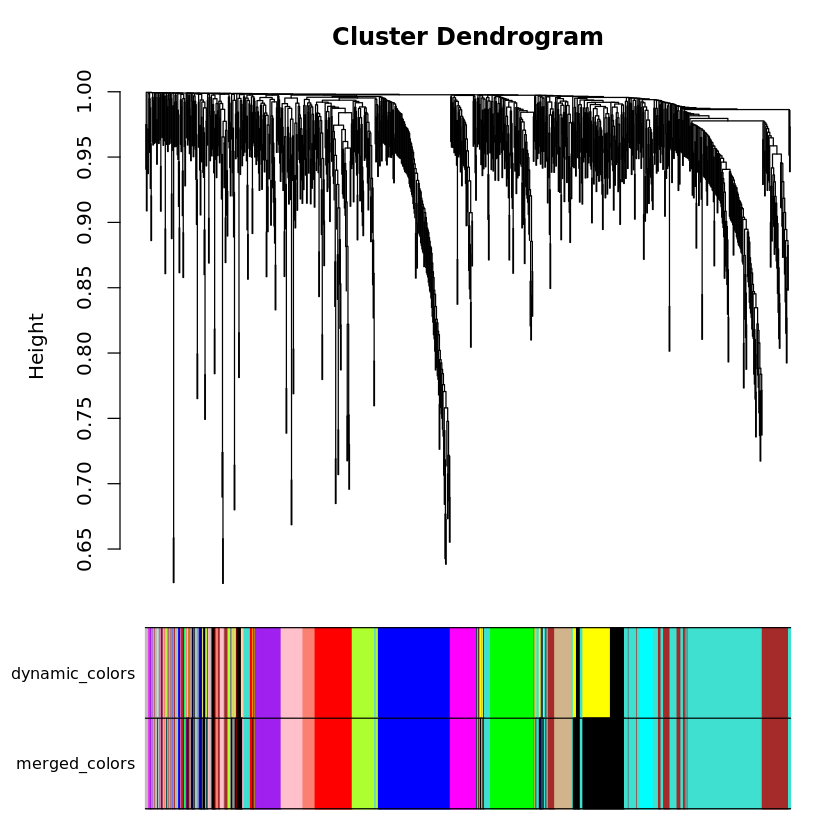

In [130]:
plotDendroAndColors(
    gene_tree, 
    cbind(dynamic_colors, merged_colors),
    dendroLabels = FALSE
)

In [131]:
module_colors <- merged_colors
color_order <- c("grey", standardColors())
module_labels <- match(module_colors, color_order) - 1
mes <- merged_mes

In [132]:
save(
    mes,
    module_labels,
    module_colors,
    gene_tree,
    soft_power,
    file = paste0(dirs$data_dir, "/saved_network_objects/", unified_dsets[dset_idx], "_tumor_network.RData")
)